Импорт необходимых библиотек

In [1]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import datasets

import numpy as np
import matplotlib.pyplot as plt

from tqdm.auto import tqdm
from datasets import load_dataset
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
import nltk

from collections import Counter
from typing import List
import string

import seaborn
seaborn.set_theme(palette='summer')

from scipy.special import softmax

In [2]:
nltk.download('punkt')

[nltk_data] Error loading punkt: <urlopen error [WinError 10060]
[nltk_data]     Попытка установить соединение была безуспешной, т.к.
[nltk_data]     от другого компьютера за требуемое время не получен
[nltk_data]     нужный отклик, или было разорвано уже установленное
[nltk_data]     соединение из-за неверного отклика уже подключенного
[nltk_data]     компьютера>


False

In [15]:
torch.cuda.is_available()

False

In [14]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cpu'

In [4]:
# Загрузим датасет
dataset = datasets.load_dataset('ag_news')

In [5]:
words = Counter()

for example in tqdm(dataset['train']['text']):
    # Приводим к нижнему регистру и убираем пунктуацию
    prccessed_text = example.lower().translate(
        str.maketrans('', '', string.punctuation))

    for word in word_tokenize(prccessed_text):
        words[word] += 1


vocab = set(['<unk>', '<bos>', '<eos>', '<pad>'])
counter_threshold = 25

for char, cnt in words.items():
    if cnt > counter_threshold:
        vocab.add(char)

print(f'Размер словаря: {len(vocab)}')

word2ind = {char: i for i, char in enumerate(vocab)}
ind2word = {i: char for char, i in word2ind.items()}

  0%|          | 0/120000 [00:00<?, ?it/s]

Размер словаря: 11842


In [6]:
class WordDataset:
    def __init__(self, sentences):
        self.data = sentences
        self.unk_id = word2ind['<unk>']
        self.bos_id = word2ind['<bos>']
        self.eos_id = word2ind['<eos>']
        self.pad_id = word2ind['<pad>']

    def __getitem__(self, idx: int) -> List[int]:
        processed_text = self.data[idx]['text'].lower().translate(
            str.maketrans('', '', string.punctuation))
        tokenized_sentence = [self.bos_id]
        tokenized_sentence += [
            word2ind.get(word, self.unk_id) for word in word_tokenize(processed_text)
            ] 
        tokenized_sentence += [self.eos_id]

        train_sample = {
            "text": tokenized_sentence,
            "label": self.data[idx]['label']
        }

        return train_sample

    def __len__(self) -> int:
        return len(self.data)


def collate_fn_with_padding(input_batch: List[List[int]], pad_id=word2ind['<pad>'], max_len=256) -> torch.Tensor:
    seq_lens = [len(x['text']) for x in input_batch]
    max_seq_len = min(max(seq_lens), max_len)

    new_batch = []
    for sequence in input_batch:
        sequence['text'] = sequence['text'][:max_seq_len]
        for _ in range(max_seq_len - len(sequence['text'])):
            sequence['text'].append(pad_id)

        new_batch.append(sequence['text'])
    
    sequences = torch.LongTensor(new_batch).to(device)
    labels = torch.LongTensor([x['label'] for x in input_batch]).to(device)

    new_batch = {
        'input_ids': sequences,
        'label': labels
    }

    return new_batch

In [7]:
train_dataset = WordDataset(dataset['train'])

np.random.seed(42)
idx = np.random.choice(np.arange(len(dataset['test'])), 5000)
eval_dataset = WordDataset(dataset['test'].select(idx))

batch_size = 32
train_dataloader = DataLoader(
    train_dataset, shuffle=True, collate_fn=collate_fn_with_padding, batch_size=batch_size)

eval_dataloader = DataLoader(
    eval_dataset, shuffle=False, collate_fn=collate_fn_with_padding, batch_size=batch_size)

In [8]:
def evaluate(model, eval_dataloader) -> float:
    predictions = []
    target = []
    with torch.no_grad():
        for batch in eval_dataloader:
            logits = model(batch['input_ids'])
            predictions.append(logits.argmax(dim=1))
            target.append(batch['label'])
    
    predictions = torch.cat(predictions)
    target = torch.cat(target)
    accuracy = (predictions == target).float().mean().item()

    return accuracy

In [9]:
class CharLM(nn.Module):
    def __init__(self, hidden_dim: int, vocab_size: int, num_classes: int = 4, aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.rnn = nn.RNN(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.rnn(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction
    
class CharLM_GRU(nn.Module): #новый класс модели. единственное отличие - это использование gru вместо rnn
    def __init__(self, hidden_dim: int, vocab_size: int, num_classes: int = 4, aggregation_type: str = 'max'):
        super().__init__()
        self.embedding = nn.Embedding(vocab_size, hidden_dim)
        self.gru = nn.GRU(hidden_dim, hidden_dim, batch_first=True)
        self.linear = nn.Linear(hidden_dim, hidden_dim)
        self.projection = nn.Linear(hidden_dim, num_classes)

        self.non_lin = nn.Tanh()
        self.dropout = nn.Dropout(p=0.1)

        self.aggregation_type = aggregation_type

    def forward(self, input_batch) -> torch.Tensor:
        embeddings = self.embedding(input_batch)  # [batch_size, seq_len, hidden_dim]
        output, _ = self.gru(embeddings)  # [batch_size, seq_len, hidden_dim]

        if self.aggregation_type == 'max':
            output = output.max(dim=1)[0] #[batch_size, hidden_dim]
        elif self.aggregation_type == 'mean':
            output = output.mean(dim=1) #[batch_size, hidden_dim]
        else:
            raise ValueError("Invalid aggregation_type")

        output = self.dropout(self.linear(self.non_lin(output)))  # [batch_size, hidden_dim]
        prediction = self.projection(self.non_lin(output))  # [batch_size, num_classes]

        return prediction

In [10]:
def show_loss_graph(losses_type): #функция для вывода графика потерь
    for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
        plt.plot(np.arange(len(losses_type[name])), losses_type[name], color=color, label=name)

    plt.title('Losses')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

def show_acc_graph(losses_type, acc_type): #функция для вывода графика точности
    for (name, values), color in zip(losses_type.items(), ['red', 'blue']):
        plt.plot(np.arange(len(acc_type[name][1:])), acc_type[name][1:], color=color, label=name)
        print(f"Лучшая accuracy для подхода {name}: {(max(acc_type[name]) * 100):.2f}")

    plt.title('Accuracy')
    plt.xlabel("epoch")
    plt.legend()
    plt.show()

In [11]:
def try_model_CharLM(hidden_dim, num_epoch, agg, charlm_gru=False): #функция обучения и тестирования модели
    eval_steps = len(train_dataloader) // 2

    losses_type = {}
    acc_type = {}

    for aggregation_type in agg:
        print(f"Starting training for {aggregation_type}")
        losses = []
        acc = []

        if charlm_gru: #выбор класса модели
            model = CharLM_GRU(
                hidden_dim=hidden_dim, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
        else:
            model = CharLM(
                hidden_dim=hidden_dim, vocab_size=len(vocab), aggregation_type=aggregation_type).to(device)
            
        criterion = nn.CrossEntropyLoss(ignore_index=word2ind['<pad>'])

        optimizer = torch.optim.Adam(model.parameters())

        for epoch in range(num_epoch):
            epoch_losses = []
            model.train()
            for i, batch in enumerate(tqdm(train_dataloader, desc=f'Training epoch {epoch}')):
                optimizer.zero_grad()
                logits = model(batch['input_ids'])
                loss = criterion(logits, batch['label'])
                loss.backward()
                optimizer.step()

                epoch_losses.append(loss.item())
                if i % eval_steps == 0:
                    model.eval()
                    acc.append(evaluate(model, eval_dataloader))
                    model.train()

            losses.append(sum(epoch_losses) / len(epoch_losses))

        losses_type[aggregation_type] = losses
        acc_type[aggregation_type] = acc
    
    show_loss_graph(losses_type)
    show_acc_graph(losses_type, acc_type)

In [ ]:
hidden_dim = 256                            
n_epoch = 5
try_model_CharLM(hidden_dim, n_epoch, ['max', 'mean'])

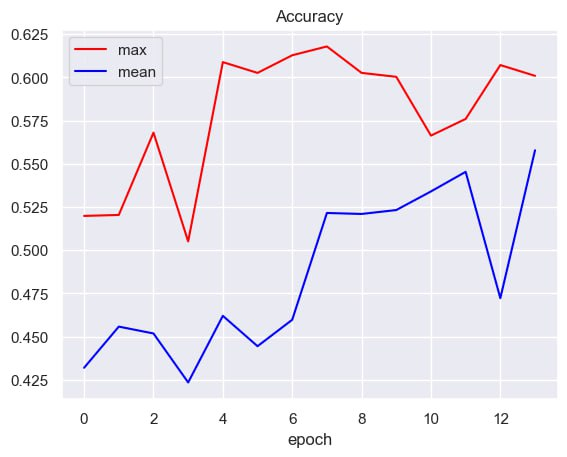